# Figure 03

Short description: This is mainly data prep
In this version, the figure 3 and its supplement get flipped

## Import libraries

In [1]:
import glob
import os
import pickle
import re
import sys
import time

import matplotlib.pyplot as plt
import matplotlib.transforms as mtrans
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from matplotlib.colors import ListedColormap, LogNorm, LinearSegmentedColormap
from scipy.stats import poisson

## Parameters and functions

In [29]:
def phi(
    population_size: int or float,
    selcoef: float,
    deleterious_mutation_rate: float,
    to_str: bool = True,
    strfmt: str = r".3g",
) -> str:
    """Calculate the independent lineage criterion based on Nicolaisen and
    Desai (2012).

    The independent lineage criterion, denoted as phi (φ), is used to quantify the impact of
    selection and mutation on genetic diversity in a population.

    Args:
        population_size (float): The effective population size.
        deleterious_mutation_rate (float): The rate of deleterious mutations per generation.
        selcoef (float): The selection coefficient.

    Returns:
        str: The string-formatted calculated value of the independent lineage criterion.

    Raises:
        AssertionError: If any of the input arguments are not greater than zero.

    Examples:
        >>> phi(1000, 0.01, 0.1)
        9.04837418035918

    References:
        - Nicolaisen and Desai (2012). Distortions in genealogies due to purifying selection. Mol.
          Biol. Evol. 29(11): 3589-3600
    """
    assert selcoef >= 0, "Selection coefficient must be greater (or eq) than zero."


    if selcoef > 0:
        my_phi = population_size * selcoef * np.exp(-deleterious_mutation_rate / selcoef)
    elif selcoef == 0:
        my_phi = 0
    else:
        assert False, "unknown selcoef, please check the code of this function"


    if to_str:
        my_phi = f"{my_phi:{strfmt}}"

    return my_phi

In [2]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np

class SeabornFig2Grid():

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

In [3]:
def extract_values(filename):
    fsplit = re.split(r"/|_|,", filename.split(".gzip")[0])
    return tuple(map(float, [fsplit[fsplit.index("popsize")+1], fsplit[fsplit.index("delmutrate")+1], fsplit[fsplit.index("selcoeff")+1]]))

## Data upload and processing

In [4]:
# go and check manually where to find the absolute path of the provided windows link

In [5]:
path = "pipeline_data_figure3/v01/results/table/popsize*.gzip"
files = glob.glob(path)
sorted_filenames = sorted(files, key=extract_values)
print(f"Num files: {len(sorted_filenames)}")

Num files: 184


In [6]:
params_list = []
click_rate_list = []
profile_list = []

for f in sorted_filenames:
    df = pd.read_pickle(f)

    # assert the random number seed
    assert all(len(df[_].unique()) == 1 for _ in ("N", "s", "U")), "Your table is not unique on the parameters"
    assert not df["rng_seed"].duplicated().any(), "You reused the same rng_seed for your simulation"


    # get click_rate
    click_rate = df["click_rate"]
    
    # get profiles
    max_length = df["profile"].apply(len).max()
    profile = pd.DataFrame(df["profile"].apply(lambda x: np.pad(x, (0, max_length - len(x)), 'constant')).to_list(), columns=range(max_length))

    # remove profile from original data frame
    df.drop("profile", axis=1, inplace=True)
    df.drop("click_rate", axis=1, inplace=True)

    # save data to list
    params_list.append(df)
    click_rate_list.append(click_rate)
    profile_list.append(profile)

In [7]:
click_rate_complete = pd.concat([pd.concat(params_list), pd.concat(click_rate_list)], axis=1)
click_rate_complete["Ns"] = click_rate_complete["N"] * click_rate_complete["s"]
click_rate_complete["NU"] = click_rate_complete["N"].astype(str) + "_" + click_rate_complete["U"].astype(str)
click_rate_complete = click_rate_complete.loc[click_rate_complete["s"] > 0]

In [8]:
click_rate_complete.U.unique(), click_rate_complete.N.unique(), click_rate_complete.s.unique()

(array([7.70e-04, 4.00e-03, 6.00e-03, 1.00e-04, 3.16e-04, 1.00e-03,
        3.16e-03, 1.00e-02, 3.16e-02, 1.00e-01, 3.16e-01, 1.00e+00,
        3.16e+00]),
 array([2000, 5000]),
 array([2.0e-06, 1.0e-05, 5.0e-05, 1.0e-04, 1.5e-04, 4.0e-04, 1.0e-03,
        2.0e-03, 4.1e-03, 1.0e-02, 1.0e-01, 1.0e+00, 2.5e-05, 8.0e-06,
        2.0e-05, 8.0e-05, 2.0e-04, 8.0e-04, 8.0e-03, 2.0e-02, 8.0e-02,
        2.0e-01, 4.0e-05, 6.0e-05]))

In [9]:
# subset data
# identify the indices
parid_list = []
N_list, s_list, U_list = [], [], []
for parid, params in enumerate(params_list):
    assert len(params.N.unique()) == 1, f"The parameter for this dataset is not unique: {params.N.unique()}"
    assert len(params.s.unique()) == 1, f"The parameter for this dataset is not unique: {params.s.unique()}"
    assert len(params.U.unique()) == 1, f"The parameter for this dataset is not unique: {params.U.unique()}"

    parid_list.append(parid)
    N_list.append(params.N.unique()[0])
    s_list.append(params.s.unique()[0])
    U_list.append(params.U.unique()[0])

params_df = pd.DataFrame(dict(N = N_list, s=s_list, U=U_list), index=parid_list)
assert not params_df.duplicated().any(), "You have parameter duplicates"

params_df["Ns"] = params_df["N"] * params_df["s"]
params_df_006 = params_df.loc[params_df["U"] == 0.006]
params_df_00077 = params_df.loc[params_df["U"] == 0.00077]

params_df_006_2k = params_df_006.loc[params_df_006["N"] == 2000]
params_df_00077_2k = params_df_00077.loc[params_df_00077["N"] == 2000]

params_df_006 = params_df_006.loc[params_df_006["N"] == 5000]
params_df_00077 = params_df_00077.loc[params_df_00077["N"] == 5000]

assert ((np.array(sorted(params_df_006.Ns.unique())) == np.array(sorted(params_df_00077.Ns.unique()))).all()), "Not same selection strength; this may require a better subsetting"

In [10]:
profile_006_list = []
for pid in params_df_006.index:
    df = profile_list[pid]
    df["N"] = int(round(params_df_006.loc[pid, :].N))
    df["s"] = params_df_006.loc[pid, :].s
    df["U"] = params_df_006.loc[pid, :].U
    df["NsU"] = df["N"].apply(str) + "_" + df["s"].apply(str) + "_" + df["U"].apply(str)
    df["click_rate"] = click_rate_list[pid].mean()

    profile_006_list.append(df.melt(id_vars=["N", "s", "U", "NsU", "click_rate"], var_name="$h_k$", value_name="freq"))

profile_006_long = pd.concat(profile_006_list)
profile_006_long["$Ns$"] = profile_006_long["N"] * profile_006_long["s"]
profile_006_long["Strength"] = profile_006_long["click_rate"].apply(lambda x: "strong" if x < 0.01 else "weak")
#pd.concat([profile_list[_].assign() for _ in params_df_006.index])
profile_006_long.head()

,N,s,U,NsU,click_rate,$h_k$,freq,$Ns$,Strength
0,5000,0.0,0.006,5000_0.0_0.006,0.995939,0,0.000344,0.0,weak
1,5000,0.0,0.006,5000_0.0_0.006,0.995939,0,0.000591,0.0,weak
2,5000,0.0,0.006,5000_0.0_0.006,0.995939,0,0.000057,0.0,weak
3,5000,0.0,0.006,5000_0.0_0.006,0.995939,0,0.000421,0.0,weak
4,5000,0.0,0.006,5000_0.0_0.006,0.995939,0,0.001040,0.0,weak


In [11]:
profile_006_2k_list = []
for pid in params_df_006_2k.index:
    df = profile_list[pid]
    df["N"] = int(round(params_df_006_2k.loc[pid, :].N))
    df["s"] = params_df_006_2k.loc[pid, :].s
    df["U"] = params_df_006_2k.loc[pid, :].U
    df["NsU"] = df["N"].apply(str) + "_" + df["s"].apply(str) + "_" + df["U"].apply(str)
    df["click_rate"] = click_rate_list[pid].mean()

    profile_006_2k_list.append(df.melt(id_vars=["N", "s", "U", "NsU", "click_rate"], var_name="$h_k$", value_name="freq"))

profile_006_2k_long = pd.concat(profile_006_2k_list)
profile_006_2k_long["$Ns$"] = profile_006_2k_long["N"] * profile_006_2k_long["s"]
profile_006_2k_long["Strength"] = profile_006_2k_long["click_rate"].apply(lambda x: "strong" if x < 0.01 else "weak")
#pd.concat([profile_list[_].assign() for _ in params_df_006.index])
profile_006_2k_long.head()

,N,s,U,NsU,click_rate,$h_k$,freq,$Ns$,Strength
0,2000,0.000002,0.006,2000_2e-06_0.006,1.006694,0,0.003995,0.004,weak
1,2000,0.000002,0.006,2000_2e-06_0.006,1.006694,0,0.001412,0.004,weak
2,2000,0.000002,0.006,2000_2e-06_0.006,1.006694,0,0.007871,0.004,weak
3,2000,0.000002,0.006,2000_2e-06_0.006,1.006694,0,0.000959,0.004,weak
4,2000,0.000002,0.006,2000_2e-06_0.006,1.006694,0,0.000861,0.004,weak


In [12]:
profile_00077_list = []
for pid in params_df_00077.index:
    df = profile_list[pid]
    df["N"] = int(round(params_df_00077.loc[pid, :].N))
    df["s"] = params_df_00077.loc[pid, :].s
    df["U"] = params_df_00077.loc[pid, :].U
    df["NsU"] = df["N"].apply(str) + "_" + df["s"].apply(str) + "_" + df["U"].apply(str)
    df["click_rate"] = click_rate_list[pid].mean()

    profile_00077_list.append(df.melt(id_vars=["N", "s", "U", "NsU", "click_rate"], var_name="$h_k$", value_name="freq"))

profile_00077_long = pd.concat(profile_00077_list)
profile_00077_long["$Ns$"] = profile_00077_long["N"] * profile_00077_long["s"]
profile_00077_long["Strength"] = profile_00077_long["click_rate"].apply(lambda x: "strong" if x < 0.01 else "weak")
#pd.concat([profile_list[_].assign() for _ in params_df_006.index])
profile_00077_long.head()

,N,s,U,NsU,click_rate,$h_k$,freq,$Ns$,Strength
0,5000,0.0,0.00077,5000_0.0_0.00077,0.983176,0,0.035110,0.0,weak
1,5000,0.0,0.00077,5000_0.0_0.00077,0.983176,0,0.046445,0.0,weak
2,5000,0.0,0.00077,5000_0.0_0.00077,0.983176,0,0.011648,0.0,weak
3,5000,0.0,0.00077,5000_0.0_0.00077,0.983176,0,0.007980,0.0,weak
4,5000,0.0,0.00077,5000_0.0_0.00077,0.983176,0,0.011843,0.0,weak


In [13]:
profile_00077_2k_list = []
for pid in params_df_00077_2k.index:
    df = profile_list[pid]
    df["N"] = int(round(params_df_00077_2k.loc[pid, :].N))
    df["s"] = params_df_00077_2k.loc[pid, :].s
    df["U"] = params_df_00077_2k.loc[pid, :].U
    df["NsU"] = df["N"].apply(str) + "_" + df["s"].apply(str) + "_" + df["U"].apply(str)
    df["click_rate"] = click_rate_list[pid].mean()

    profile_00077_2k_list.append(df.melt(id_vars=["N", "s", "U", "NsU", "click_rate"], var_name="$h_k$", value_name="freq"))

profile_00077_2k_long = pd.concat(profile_00077_2k_list)
profile_00077_2k_long["$Ns$"] = profile_00077_2k_long["N"] * profile_00077_2k_long["s"]
profile_00077_2k_long["Strength"] = profile_00077_2k_long["click_rate"].apply(lambda x: "strong" if x < 0.01 else "weak")
#pd.concat([profile_list[_].assign() for _ in params_df_006.index])
profile_00077_2k_long.head()

,N,s,U,NsU,click_rate,$h_k$,freq,$Ns$,Strength
0,2000,0.000002,0.00077,2000_2e-06_0.00077,1.07714,0,0.067134,0.004,weak
1,2000,0.000002,0.00077,2000_2e-06_0.00077,1.07714,0,0.037939,0.004,weak
2,2000,0.000002,0.00077,2000_2e-06_0.00077,1.07714,0,0.428123,0.004,weak
3,2000,0.000002,0.00077,2000_2e-06_0.00077,1.07714,0,0.101878,0.004,weak
4,2000,0.000002,0.00077,2000_2e-06_0.00077,1.07714,0,0.034410,0.004,weak


In [14]:
np.array(sorted(profile_006_long.s.unique()))

array([0.0e+00, 2.0e-06, 1.0e-05, 2.0e-05, 4.0e-05, 6.0e-05, 1.0e-04,
       4.0e-04, 1.0e-03, 2.0e-03, 4.1e-03, 1.0e-02, 1.0e-01, 1.0e+00])

In [15]:
nsub = click_rate_complete.loc[click_rate_complete.N == 5000]
nsub = nsub.loc[nsub.U.isin([1e-4, 1e-3, 1e-2, 1e-1, 1, 3.16e-4, 3.16e-3, 3.16e-2, 3.16e-1, 3.16])]
nsub["lU"] = np.log(nsub["U"])
print(sorted(nsub.U.unique()))
nsub = nsub.rename(columns={"U": "$U_d$"})
nsub.head()

[0.0001, 0.000316, 0.001, 0.00316, 0.01, 0.0316, 0.1, 0.316, 1.0, 3.16]


,rng_seed,N,s,$U_d$,click_rate,Ns,NU,lU
0,2283182489,5000,0.000002,0.0001,0.106459,0.01,5000_0.0001,-9.21034
1,3063854464,5000,0.000002,0.0001,-0.593985,0.01,5000_0.0001,-9.21034
2,335197160,5000,0.000002,0.0001,-0.388446,0.01,5000_0.0001,-9.21034
3,2609705121,5000,0.000002,0.0001,0.219464,0.01,5000_0.0001,-9.21034
4,3948923896,5000,0.000002,0.0001,0.630534,0.01,5000_0.0001,-9.21034


## Visualisation

In [16]:
# panel a function
def make_panelA(ax):
    
    ax.axhline(0, linestyle="dashed", color="gray")
    ax.axhline(1, linestyle="dashed", color="gray")
    
    
    sns.lineplot(
        click_rate_complete.loc[click_rate_complete.U.isin((0.00077, 0.006))],
        x="Ns",
        y="click_rate",
        hue="U",
        size="N",
        style="U",
        markers=True,
        markersize=7,
        dashes=False,
        errorbar=("ci", 95),
        palette=sns.diverging_palette(220, 20, as_cmap=True),
        #palette=["Orange", "Blue"],
        ax=ax
    )
    
    ax.set_xscale("log")
    ax.set_xlim(5.5e-3, 1.05*1e2)
    ax.set_ylim(-0.05, 1.05)
    
    legend = ax.legend(
        #loc="upper right",
        framealpha=0.95
    )
    legend.texts[0].set_text("$U_d$")
    legend.texts[1].set_text("$7.7 \cdot 10^{-4}$")
    legend.texts[2].set_text("$6 \cdot 10^{-3}$")
    legend.texts[3].set_text("$N$")
    
    #plt.legend(loc="upper right", framealpha=0.95)
    
    
    ax.set_xlabel("Selection strength $N \cdot s$")
    ax.set_ylabel("Relative click rate")

In [17]:
def make_profile_panel(dataset, ax, my_xlim, my_cmap, legend=True):

    my_markers = ["X", "s"]  # weak, strong

    if len(dataset["Strength"].unique()) == 1:
        strength_value = dataset["Strength"].unique()[0]
        if strength_value == "weak":
            my_markers = ["X"]
        else:
            my_markers = ["s"]
    
    sns.lineplot(
        data = dataset,
        x="$h_k$",
        y="freq",
        style="Strength",
        markers=my_markers,
        markersize=12,
        dashes=False,
        hue="s",
        hue_norm=LogNorm(),
        errorbar="ci",
        err_style="bars",
        palette=my_cmap,
        ax=ax
    )
    
    
    ax.set_xticks(np.arange(0, 100))
    ax.set_xlim(-0.05*10 + my_xlim[0], 0.05 * 10 + my_xlim[1])
    ax.set_ylim(-0.05, 0.45)

    ax.set_xlabel("Mutation load class $h_k$")
    ax.set_ylabel("Frequency")

    
    if legend:
        legend = ax.legend(ncol=1,
        framealpha=0.95, fontsize =12)
        legend.texts[0].set_text("$s$")
        legend.texts[6].set_text("Selection")
    else:
        ax.get_legend().remove()

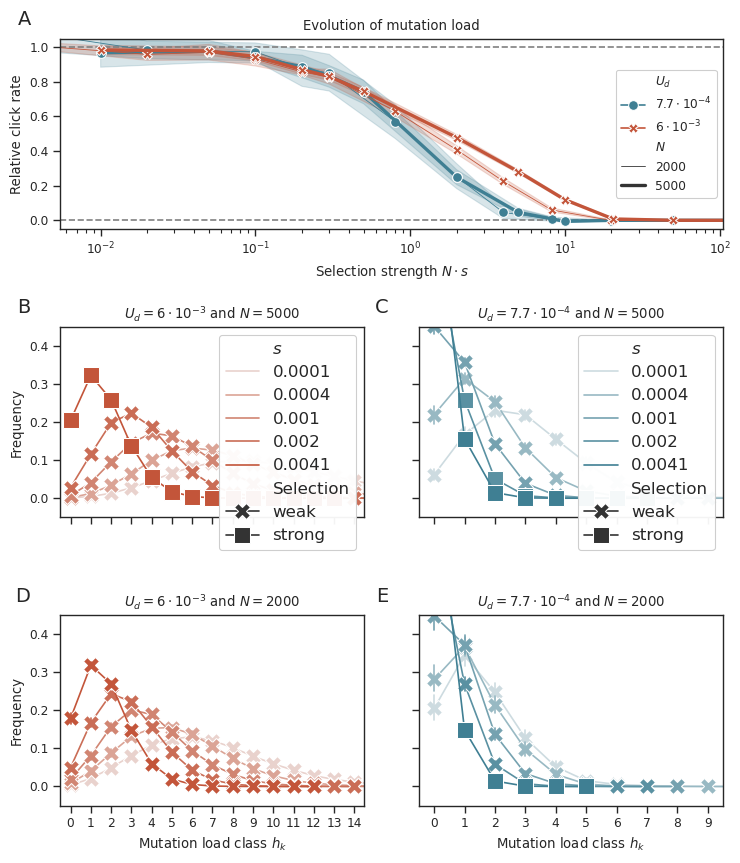

In [18]:
old_style=True
if old_style:
    sns.set(style="ticks", context="paper", font_scale=1.0)
    
    fig = plt.figure(figsize=(7.5, 8.75))
    gs = fig.add_gridspec(nrows=6, ncols=2)
    ax0 = fig.add_subplot(gs[0:2, :])
    ax1 = fig.add_subplot(gs[2:4, 0])
    ax2 = fig.add_subplot(gs[2:4, 1])
    ax3 = fig.add_subplot(gs[4:, 0])
    ax4 = fig.add_subplot(gs[4:, 1])
    
    
    # make panel A
    make_panelA(ax=ax0)
    
    # make other panels
    c1 = sns.diverging_palette(220, 20)[0]
    c2 = sns.diverging_palette(220, 20)[2]
    cmap_blues = LinearSegmentedColormap.from_list('custom_cmap', [c2, c1])
    c1 = sns.diverging_palette(220, 20)[-3]
    c2 = sns.diverging_palette(220, 20)[-1]
    cmap_reds = LinearSegmentedColormap.from_list('custom_cmap', [c1, c2])
    
    # panel B
    make_profile_panel(
        dataset=profile_006_long.loc[profile_006_long.s.isin(np.array(sorted(profile_006_long.s.unique(), reverse=True))[3:8])],
        ax=ax1,
        my_xlim=(0, 14),
        my_cmap=cmap_reds,
        legend=True
    )
    make_profile_panel(
        dataset=profile_00077_long.loc[profile_00077_long.s.isin(np.array(sorted(profile_006_long.s.unique(), reverse=True))[3:8])],
        ax=ax2,
        my_xlim=(0, 9),
        my_cmap=cmap_blues,
        legend=True
    )
    
    
    # panel D
    make_profile_panel(
        dataset=profile_006_2k_long.loc[profile_006_2k_long.s.isin(np.array(sorted(profile_006_long.s.unique(), reverse=True))[3:8])],
        ax=ax3,
        my_xlim=(0, 14),
        my_cmap=cmap_reds,
        legend=False
    )
    make_profile_panel(
        dataset=profile_00077_2k_long.loc[profile_00077_2k_long.s.isin(np.array(sorted(profile_006_long.s.unique(), reverse=True))[3:8])],
        ax=ax4,
        my_xlim=(0, 9),
        my_cmap=cmap_blues,
        legend=False
    )
    
    ax0.set_title("Evolution of mutation load")
    ax1.set_title("$U_d = 6 \cdot 10^{-3}$ and $N = 5000$")
    ax2.set_title("$U_d = 7.7 \cdot 10^{-4}$ and $N = 5000$")
    ax3.set_title("$U_d = 6 \cdot 10^{-3}$ and $N = 2000$")
    ax4.set_title("$U_d = 7.7 \cdot 10^{-4}$ and $N = 2000$")
    
    
    axes = [ax0, ax1, ax2, ax3, ax4]
    labels = ["A", "B", "C", "D", "E"]
    for ax_, label_ in zip(axes, labels):
        if label_ == "A":
            ax_.text(
                -.045, 1.15, label_,
                transform=ax_.transAxes,
                fontsize=14,
                va='top',
                ha='right'
            )
        else:
            ax_.text(
                -0.1, 1.15, label_,
                transform=ax_.transAxes,
                fontsize=14,
                va='top',
                ha='right'
            )
    
    # remove labels which are bad
    # [[B, C],
    #  [D, E]]
    ax1.set_xlabel(None)
    ax1.set_xticklabels([])
    ax2.set_xlabel(None)
    ax2.set_xticklabels([])
    ax2.set_ylabel(None)
    ax2.set_yticklabels([])
    ax4.set_ylabel(None)
    ax4.set_yticklabels([])
    
    
    plt.tight_layout()
    
    plt.show()
    plt.close()

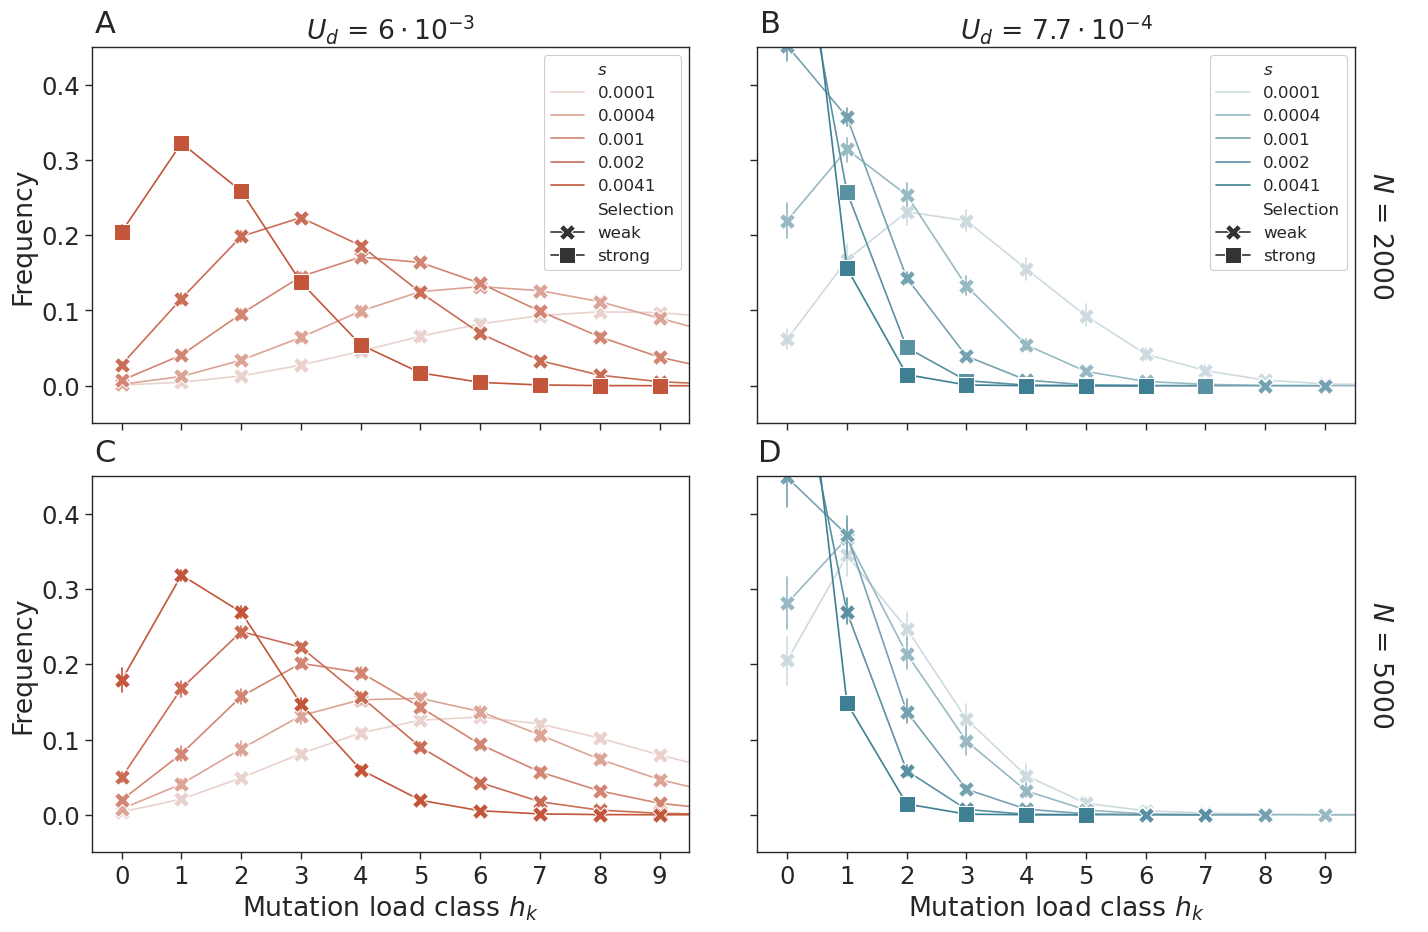

In [19]:
sns.set(style="ticks", context="paper", font_scale=2)
figsize=(7, 7/3 *2)  # width height
#sns.set_theme()

# create the data frame for the four panels
combined_profiles = pd.concat([
    profile_006_long.loc[profile_006_long.s.isin(np.array(sorted(profile_006_long.s.unique(), reverse=True))[3:8])],
    profile_00077_long.loc[profile_00077_long.s.isin(np.array(sorted(profile_006_long.s.unique(), reverse=True))[3:8])],
    profile_006_2k_long.loc[profile_006_2k_long.s.isin(np.array(sorted(profile_006_long.s.unique(), reverse=True))[3:8])],
    profile_00077_2k_long.loc[profile_00077_2k_long.s.isin(np.array(sorted(profile_006_long.s.unique(), reverse=True))[3:8])]
])

def make_latex(my_num):
    if my_num == 0.006:
        return "$6 \cdot 10^{-3}$"
    elif my_num == 0.00077:
        return "$7.7 \cdot 10^{-4}$"
combined_profiles["$U_d$"] = combined_profiles["U"].apply(make_latex)
combined_profiles["$N$"] = combined_profiles["N"]

# Create FacetGrid with lineplots
g = sns.FacetGrid(
    combined_profiles,
    col="$U_d$",
    row="$N$",
    margin_titles=True,
    despine=False,
    height=figsize[1],
    aspect=figsize[0]/figsize[1]
)


c1 = sns.diverging_palette(220, 20)[0]
c2 = sns.diverging_palette(220, 20)[2]
cmap_blues = LinearSegmentedColormap.from_list('custom_cmap', [c2, c1])
c1 = sns.diverging_palette(220, 20)[-3]
c2 = sns.diverging_palette(220, 20)[-1]
cmap_reds = LinearSegmentedColormap.from_list('custom_cmap', [c1, c2])
my_markers = ["X", "s"]  # weak, strong

#g.fig.subplots_adjust(wspace=0, hspace=0)

g.add_legend()

# Access individual axes and set xlim and ylim
for axid, ax in enumerate(g.axes.flat, start=1):
    if axid == 1:
        make_profile_panel(
            dataset=profile_006_long.loc[profile_006_long.s.isin(np.array(sorted(profile_006_long.s.unique(), reverse=True))[3:8])],
            ax=ax,
            my_xlim=(0, 14),
            my_cmap=cmap_reds,
            legend=True
        )

    if axid == 2:
        make_profile_panel(
            dataset=profile_00077_long.loc[profile_00077_long.s.isin(np.array(sorted(profile_006_long.s.unique(), reverse=True))[3:8])],
            ax=ax,
            my_xlim=(0, 9),
            my_cmap=cmap_blues,
            legend=True
        )
    
    if axid == 3:
        make_profile_panel(
            dataset=profile_006_2k_long.loc[profile_006_2k_long.s.isin(np.array(sorted(profile_006_long.s.unique(), reverse=True))[3:8])],
            ax=ax,
            my_xlim=(0, 14),
            my_cmap=cmap_reds,
            legend=False
        )

    if axid == 4:
        make_profile_panel(
            dataset=profile_00077_2k_long.loc[profile_00077_2k_long.s.isin(np.array(sorted(profile_006_long.s.unique(), reverse=True))[3:8])],
            ax=ax,
            my_xlim=(0, 9),
            my_cmap=cmap_blues,
            legend=False
        )

labels = ["A", "B", "C", "D"]
for ax_, label_ in zip(g.axes.flat, labels):
    ax_.text(
        0.04, 1.1, label_,
        transform=ax_.transAxes,
        fontsize=22,
        va='top',
        ha='right'
    )
        
fig = plt.gcf()
plt.show()
plt.close()

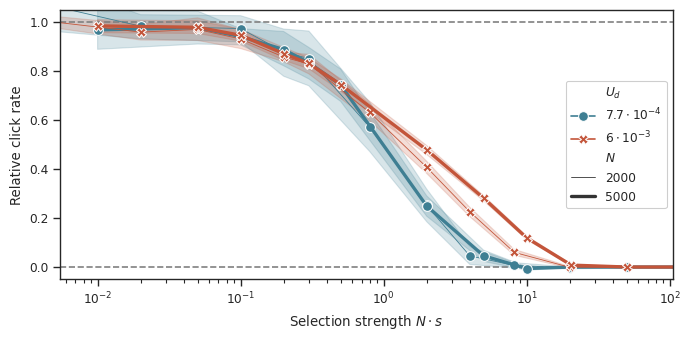

In [20]:
sns.set(style="ticks", context="paper", font_scale=1.0)
fig_s2, ax = plt.subplots(figsize=(7, 3.5))

make_panelA(ax=ax)
plt.tight_layout()
plt.show()
plt.close()

In [107]:
# find the labels
nsub["phi"] = nsub.apply(
    lambda row: phi(
        population_size=row['N'],
        selcoef=row['s'],
        deleterious_mutation_rate=row['$U_d$'],
        to_str=True
    ),
    axis=1
)
a = nsub.copy()
a = a.loc[a["$U_d$"] == 1e-4]
a = a.loc[a["Ns"].isin([0.1, 0.4, 1.00, 4.e+02, 4.e+01])]
#a = a.loc[a["Ns"] in [1e-1, 1e0, 1e1, 1e2]]
a = a.groupby("phi")[['N', 's', '$U_d$', "Ns", 'click_rate']].mean().reset_index(inplace=False)


b = nsub.copy()
b = b.loc[b["$U_d$"] == 3.16e-01]
b = b.loc[b["Ns"].isin([ 4.00, 1.e+02, 4.e+01])]
#a = a.loc[a["Ns"] in [1e-1, 1e0, 1e1, 1e2]]
b = b.groupby("phi")[['N', 's', '$U_d$', "Ns", 'click_rate']].mean().reset_index(inplace=False)

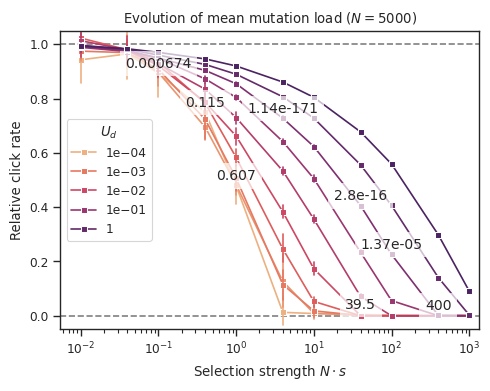

In [113]:
sns.set(style="ticks", context="paper", font_scale=1)

fig_s1, ax = plt.subplots(figsize=(5, 4))


ax.axhline(0, linestyle="dashed", color="gray")
ax.axhline(1, linestyle="dashed", color="gray")


def create_custom_cmap(colors, name='custom_cmap'):
    """Create a custom colormap using LinearSegmentedColormap."""
    cmap = LinearSegmentedColormap.from_list(name, colors)
    return cmap

# my_custom_colors = ['#f6eff7','#bdc9e1','#67a9cf','#1c9099','#016c59']  # from figure 2
custom_colors = [(0, '#ba84c2'),(0.5, '#67a9cf'), (1, '#016c59')]
custom_cmap = create_custom_cmap(custom_colors)


sns.lineplot(
    nsub,
    x="Ns",
    y="click_rate",
    hue="$U_d$",
    hue_norm=LogNorm(),
    #style=10,
    marker="s",
    dashes=False,
    errorbar=("ci", 95),
    palette="flare",
    #palette=custom_cmap,
    err_style="bars",
    ax=ax
)

ax.set_xscale("log")
ax.set_xlim(5.5e-3, 1.35e3)
ax.set_ylim(-0.05, 1.05)

#plt.legend(loc="upper right", framealpha=0.95)


ax.set_xlabel("Selection strength $  N \cdot s  $")
ax.set_ylabel("Relative click rate")

ax.set_title("Evolution of mean mutation load ($N=5000$)")

# text labels
x_offset=0
y_offset=+0.01
for i in a.index:
    plt.text(a["Ns"][i]+x_offset, a["click_rate"][i]+y_offset, a["phi"][i],
             fontsize=10, ha='center', va='bottom', bbox=dict(facecolor="white", edgecolor='none', alpha=0.7))

for i in b.index:
    plt.text(b["Ns"][i]+x_offset, b["click_rate"][i]+y_offset, b["phi"][i],
             fontsize=10, ha='center', va='bottom', bbox=dict(facecolor="white", edgecolor='none', alpha=0.7))




plt.tight_layout()

plt.show()
plt.close()

## Save data and figure

### 

In [114]:
# get the highest version of the figure and name filename one higher
existing_versions = [int(re.search(r'v(\d+)', filename).group(1)) for filename in glob.glob("figure3_v*.png")]
if len(existing_versions):
    max_version = max(existing_versions)
else:
    max_version = 0
version = max_version + 1
assert version < 100, "Biggest version is 3 digits, you need a new string formatter"

new_filename = f"figure3_v{version:02d}.png"

plt.figure(fig_s1)
plt.savefig(new_filename, dpi=600)
plt.close()

In [115]:
# get the highest version of the figure and name filename one higher
existing_versions = [int(re.search(r'v(\d+)', filename).group(1)) for filename in glob.glob("figure3_S1_v*.png")]
if len(existing_versions):
    max_version = max(existing_versions)
else:
    max_version = 0
version = max_version + 1
assert version < 100, "Biggest version is 3 digits, you need a new string formatter"

new_filename = f"figure3_S1_v{version:02d}.png"

plt.figure(fig)
plt.savefig(new_filename, dpi=600)
plt.close()

In [116]:
# get the highest version of the figure and name filename one higher
existing_versions = [int(re.search(r'v(\d+)', filename).group(1)) for filename in glob.glob("figure3_S2_v*.png")]
if len(existing_versions):
    max_version = max(existing_versions)
else:
    max_version = 0
version = max_version + 1
assert version < 100, "Biggest version is 3 digits, you need a new string formatter"

new_filename = f"figure3_S2_v{version:02d}.png"

plt.figure(fig_s2)
plt.savefig(new_filename, dpi=600)
plt.close()